In [2]:
!python segmented_style_transfer.py

Started partial style transfer
Finished image segmentation
Returned segments:  4
torch.Size([1, 3, 512, 819])


C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
C:\Users\datta\OneDrive - HKUST Connect\GIFShop Wizard\partial style transfer repo\vision\faststyletransfer_eval.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad()

or

In [1]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib, random
import torch, torchvision
import torchvision.transforms as T
import numpy as np
import numpy.ma as ma
import cv2
from vision.faststyletransfer_eval import FasterStyleTransfer
import collections

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# default COCO objects
# Separating out the object names will be useful in object-specific filtering, but not instance segmentation
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def get_prediction(img_path, threshold, objects):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [objects[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

def instance_segmentation(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3, objects=COCO_INSTANCE_CATEGORY_NAMES):
  """
  instance_segmentation
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold, objects)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    #cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # no bounding boxes required
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  return img


In [2]:
def mask_segments(img_path='./payload/IMG-20200401-WA0002.jpg'):
    img_original = Image.open(img_path)
    img_original_rbg = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    img = transform(img_original)
    img_rgb = transform(img_original_rbg)
    pred = model([img])

    print("Finished image segmentation")
    
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    print("Returned segments: ", len(masks))
    
    return img_original_rbg, img_rgb, masks

In [3]:
def PartialStyleTransfer(segment = 0, img_path='./payload/IMG-20200401-WA0002.jpg', style_path="./fast_neural_style_transfer/models/mosaic_style__200_iter__vgg19_weights.pth"):

    print("Started partial style transfer")

    # mode can be 'styled' or 'color'

    # return indices on number of segments
    img_original_rbg, img_rgb, masks = mask_segments(img_path)

    if len(masks) > 0:
        mask = masks[segment]

        # print mask of image with the original image pixels
        img_array = np.array(img_original_rbg[:,:,:])
        img_array_floating = np.array(img_rgb[:,:,:])
        # if False, set as 0 (black)

        masked_img = []
        for h in range(img_original_rbg.shape[0]):
            sub_masked_img = []
            for i in range(img_original_rbg.shape[1]):
                tmp=[]
                for j in range(img_original_rbg.shape[2]):
                    if mask[h][i] == False:
                        tmp.append(float(0))
                    else:
                        tmp.append(img_array_floating[j][h][i])
                sub_masked_img.append(tmp)
            masked_img.append(sub_masked_img)      

        masked_img_array = np.array(masked_img)
        plt.imshow(masked_img_array[:,:,:]) # Export this mask image for style transfer
        plt.show()

        matplotlib.image.imsave(str(img_path[:-4]+str("_MASK")+".png"), masked_img_array)

        FasterStyleTransfer(style_path, str(img_path[:-4]+str("_MASK")+".png"), str(img_path[:-4]+str("_FST")+".png"))

        style_img = Image.open(str(img_path[:-4]+str("_FST")+".png"))
        plt.imshow(style_img)
        plt.show()

    return style_img, img_array_floating, img_array


In [4]:
def PixelRemoved(img_path='./payload/IMG-20200401-WA0002.jpg'):

    transform = T.Compose([T.ToTensor()])
    
    img_original_rbg = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_rgb = transform(img_original_rbg)
    img_array_floating = np.array(img_rgb[:,:,:])
    
    style_img_original = Image.open(str(img_path[:-4]+str("_FST")+".png"))
    WIDTH, HEIGHT = cv2.cvtColor(cv2.imread(str(img_path[:-4]+str("_MASK")+".png")), cv2.COLOR_BGR2RGB).shape[1], cv2.cvtColor(cv2.imread(str(img_path[:-4]+str("_MASK")+".png")), cv2.COLOR_BGR2RGB).shape[0]
    style_img_rbg = cv2.resize(cv2.cvtColor(cv2.imread(str(img_path[:-4]+str("_FST")+".png")), cv2.COLOR_BGR2RGB), (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC) # FST reshaped the dimension, this lines reshapes back to consistent dimensions
    styled_img = transform(style_img_original)
    styled_img_rgb = transform(style_img_rbg)

    # remove most frequent pixel
    pix_remove = list(dict(collections.Counter(np.hstack(np.hstack(styled_img_rgb))).most_common()).keys())[0]

    # img_array = np.array(img_original_rbg[:,:,:])
    styled_img_rgb_floating = np.array(styled_img_rgb[:,:,:])

    masked_img = []
    # When it is detected to be a background pixed, a background pixel from original image is inserted
    for h in range(style_img_rbg.shape[0]):
        sub_masked_img = []
        for i in range(style_img_rbg.shape[1]):
            tmp=[]
            for j in range(style_img_rbg.shape[2]):
                if (float(styled_img_rgb[j][h][i]) > float(pix_remove)-0.1) and (float(styled_img_rgb[j][h][i]) < float(pix_remove)+0.1):
                    tmp.append(img_array_floating[j][h][i])
                else:
                    tmp.append(styled_img_rgb_floating[j][h][i])
            sub_masked_img.append(tmp)
        masked_img.append(sub_masked_img) 

    masked_img_array = np.array(masked_img)
    plt.imshow(masked_img_array[:,:,:])

    matplotlib.image.imsave(str(img_path[:-4]+str("_MASK+FST")+".png"), masked_img_array)
    
    return masked_img_array

Started partial style transfer
Finished image segmentation
Returned segments:  4


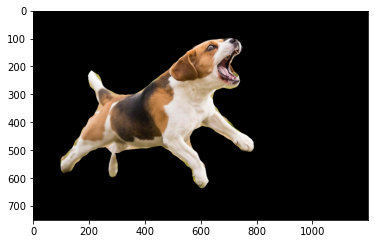

torch.Size([1, 3, 512, 819])


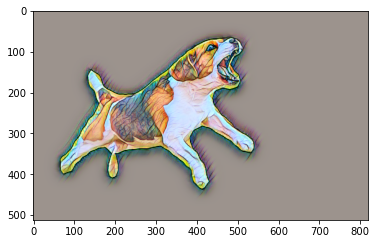

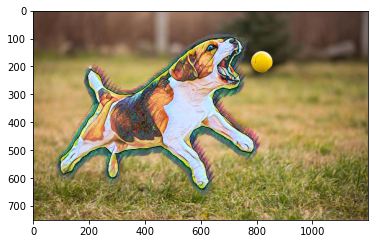

In [7]:
style_img, img_array_floating, img_array = PartialStyleTransfer(segment = 1, img_path='./payload/test.jpg', style_path="./vision/fast_neural_style_transfer/models/mosaic.pth")
masked_img_array = PixelRemoved(img_path='./payload/test.jpg')